In [1]:
%matplotlib inline
import scrublet as scr
import scipy.io
import matplotlib.pyplot as plt
import numpy as np
import os
import time


#### Download 8k PBMC data set from 10X Genomics
(Only need to do this once)

Download raw data by navigating to the following URL in your web browser:
http://cf.10xgenomics.com/samples/cell-exp/2.1.0/pbmc8k/pbmc8k_filtered_gene_bc_matrices.tar.gz

Or use wget:

In [2]:
!wget http://cf.10xgenomics.com/samples/cell-exp/2.1.0/pbmc8k/pbmc8k_filtered_gene_bc_matrices.tar.gz

--2018-07-16 16:49:19--  http://cf.10xgenomics.com/samples/cell-exp/2.1.0/pbmc8k/pbmc8k_filtered_gene_bc_matrices.tar.gz
Resolving cf.10xgenomics.com (cf.10xgenomics.com)... 13.33.35.84, 13.33.35.97, 13.33.35.175, ...
Connecting to cf.10xgenomics.com (cf.10xgenomics.com)|13.33.35.84|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 37558165 (36M) [application/x-tar]
Saving to: ‘pbmc8k_filtered_gene_bc_matrices.tar.gz’

pbmc8k_filtered_gen 100%[===================>]  35.82M  7.21MB/s    in 6.4s    

2018-07-16 16:49:25 (5.60 MB/s) - ‘pbmc8k_filtered_gene_bc_matrices.tar.gz’ saved [37558165/37558165]



Uncompress:

In [3]:
!tar xfz pbmc8k_filtered_gene_bc_matrices.tar.gz

#### Load counts matrix and gene list
The first time this is run, the counts matrix is loaded from the mtx file. An npz file is saved for fast loading in the future.

In [4]:
input_dir = 'filtered_gene_bc_matrices/GRCh38/'

# The raw counts matrix (E) should be a scipy sparse CSC matrix
# with cells as rows and genes as columns

if os.path.isfile(input_dir + '/matrix.npz'):
    E = scipy.sparse.load_npz(input_dir + '/matrix.npz')
else:
    E = scipy.io.mmread(input_dir + '/matrix.mtx').T.tocsc()
    scipy.sparse.save_npz(input_dir + '/matrix.npz', E, compressed=True)

genes = np.array(scr.load_genes(input_dir + 'genes.tsv', delimiter='\t', column=1))

print('Expression matrix shape: {} rows, {} columns'.format(E.shape[0], E.shape[1]))
print('Number of genes in gene list: {}'.format(len(genes)))

Expression matrix shape: 8381 rows, 33694 columns
Number of genes in gene list: 33694


#### Check that the distribution of total counts per cell looks reasonable (i.e., background has been filtered out)


Text(0,0.5,'Number of cells')

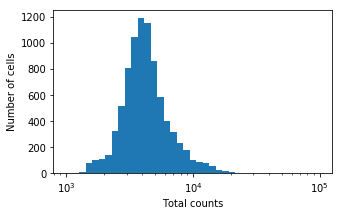

In [5]:
total_counts = E.sum(1).A.squeeze()

fig, ax = plt.subplots(figsize = (5, 3))
ax.hist(total_counts, bins = np.logspace(3, 5, 40))
ax.set_xscale('log')
ax.set_xlabel('Total counts')
ax.set_ylabel('Number of cells')


#### Calculate doublet scores


In [6]:
# filtering/preprocessing parameters:
min_counts = 2
min_cells = 3
vscore_percentile = 85
n_pc = 30

# doublet detector parameters:
expected_doublet_rate = 0.06 
sim_doublet_ratio = 3
n_neighbors = 50

t0 = time.time()

scrublet_results = scr.compute_doublet_scores(
    E, 
    min_counts = min_counts, 
    min_cells = min_cells, 
    vscore_percentile = vscore_percentile, 
    n_prin_comps = n_pc,
    scaling_method = 'zscore',
    expected_doublet_rate = expected_doublet_rate,
    sim_doublet_ratio = sim_doublet_ratio,
    n_neighbors = n_neighbors, 
    use_approx_neighbors = True, 
    get_doublet_neighbor_parents = False
)


t1 = time.time()
print('Elapsed time: {:.1f} seconds'.format(t1 - t0))

Simulating doublets
Total counts normalizing
Finding highly variable genes
Filtering genes from 33694 to 1697
Applying z-score normalization
Running PCA
Building kNN graph and calculating doublet scores
Elapsed time: 19.0 seconds


#### Get UMAP embedding to help visualize the results

In [7]:
# UMAP: https://github.com/lmcinnes/umap
import umap

embedding = umap.UMAP(n_neighbors=10).fit_transform(scrublet_results['pca_observed_cells'])


#### Set doublet score threshold and visualize results
To call doublets, manually set a threshold between the two peaks of the simulated doublet histogram.

349/8381 = 4.2% of cells are predicted doublets.
60.0% of doublets are predicted to be detectable.
Predicted overall doublet rate = 6.9%


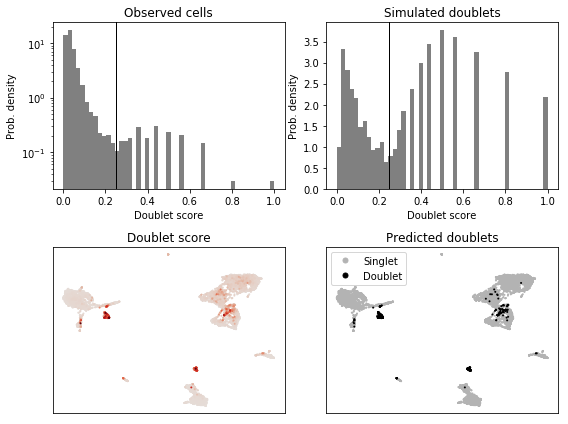

In [8]:
score_threshold = 0.25

fig, axs = scr.plot_scrublet_results(embedding, 
                                     scrublet_results['doublet_scores_observed_cells'], 
                                     scrublet_results['doublet_scores_simulated_doublets'], 
                                     score_threshold, 
                                     order_points = True, 
                                     marker_size = 4)
